In [26]:
correction_list = {
    "Kim K": "Kim K.",
    "Al Ghareeb M.": "Al-Ghareeb M.",
    "Al Khulaifi N.G.": "Al-Khulaifi N.G.",
    "Alawadhi O.": "Al-Awadhi O.",
    "Bahrouzyan O.": "Al-Awadhi O.",
    "Haji A.": "Al-Haji A.",
    "Hajji A.": "Al-Haji A.",
    "El Aarej M.": "El-Aarej M.",
    "El Amrani R.": "El-Amrani R.",
    "El Aynaoui Y.": "El-Aynaoui Y.",
    "Granollers Pujol G.": "Granollers-Pujol G.",
    "Granollers G.": "Granollers-Pujol G.",
    "Granollers M.": "Granollers-Pujol M.",
    "Al Mutawa J.": "Ali Mutawa J.M.",
    "Al-Mutawa J.": "Ali Mutawa J.M.",
    "Bogomolov Jr. A.": "Bogomolov Jr.A.",
    "Bogomolov A.": "Bogomolov Jr.A.",
    "Carreno Busta": "Carreno-Busta",
    "Chela J.": "Chela J.I.",
    "Dutra Silva R.": "Dutra da Silva R.",
    "Dutra Da Silva R.": "Dutra da Silva R.",
    "Ferrero J.": "Ferrero J.C.",
    "Gambill J. M.": "Gambill J.M.",
    "Guzman J.": "Guzman J.P.",
    "Haider-Mauer A.": "Haider-Maurer A.",
    "Zayid M. S.": "Zayid M.S.",
    "De Bakker T.": "de Bakker T.",
    "De Chaunac S.": "de Chaunac S.",
    "De Greef A.": "de Greef A.",
    "De Heart R.": "de Heart R.",
    "De Loore J.": "de Loore J.",
    "De Minaur A.": "de Minaur A.",
    "De Schepper K.": "de Schepper K.",
    "De Voest R.": "de Voest R.",
    "Del Bonis F.": "del Bonis F.",
    "Del Potro J.": "del Potro J.M.",
    "Del Potro J. M.": "del Potro J.M.",
    "Del Potro J.M.": "del Potro J.M.",
    "Van D. Merwe I.": "van D. Merwe I.",
    "Van Der Merwe I.": "van Der Merwe I.",
    "Van Lottum J.": "van Lottum J.",
    "Van Rijthoven T.": "van Rijthoven T.",
    "Van der Dium A.": "van der Dium A.",
    "Van der Merwe I.": "van der Merwe I.",
    "Munoz De La Nava D.": "Munoz de la Nava D.",
    "Munoz de La Nava D.": "Munoz de la Nava D.",
    "Munoz-De La Nava D.": "Munoz de la Nava D.",
    "Di Mauro A.": "di Mauro A.",
    "Di Pasquale A.": "di Pasquale A.",
}

drop_list = ["W1", "L1", "W2", "L2", "W3", "L3", "W4", "L4", "W5", "L5", "CBW", "CBL", "GBW", "GBL", "IWW", "IWL", "SBW", "SBL", "B&WW", "B&WL", "EXW", "EXL", "UBW", "UBL", "LBW", "LBL", "SJW", "SJL", "MaxW", "MaxL", "AvgW", "AvgL", "WPts", "LPts"]

Let's download, save, cleanup, and agregate the data into a dataframe and and save it to a csv file. We also caculate the elo rate of each player right before the game as well as the probability for the winner to win the game based on the elo rates of the two players.

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io

url_base = "http://tennis-data.co.uk/"

sess = requests.session()
df_list = []
for year in range(2000, 2013):
    url = f"{url_base}/{year}/{year}.xls"
    resp = sess.get(url)
    with open(f"archive/tournoments_{year}.xls", mode="wb") as file:
        file.write(resp.content)
    df_list.append(pd.read_excel(io.BytesIO(resp.content), sheet_name=f"{year}", engine="calamine"))

for year in range(2013, 2025):
    url = f"{url_base}/{year}/{year}.xlsx"
    resp = sess.get(url)
    with open(f"archive/tournoments_{year}.xlsx", mode="wb") as file:
        file.write(resp.content)
    df_list.append(pd.read_excel(io.BytesIO(resp.content), sheet_name=f"{year}", engine="calamine"))
sess.close()

df_atp = pd.concat(df_list, axis=0).drop(labels=drop_list, axis=1) 

df_atp["Winner"] = df_atp["Winner"].str.strip()
df_atp["Loser"] = df_atp["Loser"].str.strip()

df_atp["Winner"] = df_atp["Winner"].replace(correction_list)
df_atp["Loser"] = df_atp["Loser"].replace(correction_list)

df_atp["Best of"] = pd.to_numeric(df_atp["Best of"], errors="coerce", downcast="integer")
df_atp["WRank"] = pd.to_numeric(df_atp["WRank"], errors="coerce", downcast="integer")
df_atp["LRank"] = pd.to_numeric(df_atp["LRank"], errors="coerce", downcast="integer")

elo_start = 1500.0
k_factor = 32.0
df_atp["Date"] = pd.to_datetime(df_atp["Date"])
df_atp[["elo_winner", "elo_loser"]] = elo_start
df_atp["proba_elo"] = .5

df_atp = df_atp.sort_values(by=["ATP", "Date"]).reset_index(drop=True).copy()

elo_rates = pd.DataFrame({"Player": pd.concat([df_atp["Winner"], df_atp["Loser"]], axis=0).unique(), "elo": elo_start})
for index, _ in df_atp.iterrows():
    df_atp.loc[index, "elo_winner"] = elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Winner"], "elo"].values[0]
    df_atp.loc[index, "elo_loser"] = elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Loser"], "elo"].values[0]
    df_atp.loc[index, "proba_elo"] = 1.0/(1.0 + 10.0**(.0025*(df_atp.loc[index, "elo_loser"] - df_atp.loc[index, "elo_winner"])))
    elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Winner"], "elo"] += k_factor*(1.0 - df_atp.loc[index, "proba_elo"])
    elo_rates.loc[elo_rates["Player"]==df_atp.loc[index, "Loser"], "elo"] -= k_factor*(1.0 - df_atp.loc[index, "proba_elo"])

df_atp.to_csv("archive/atp_data.csv")
elo_rates.to_csv("archive/elo_rates.csv")

df_atp.head()

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,Wsets,Lsets,Comment,B365W,B365L,PSW,PSL,elo_winner,elo_loser,proba_elo
0,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3.0,Dosedel S.,...,2.0,0.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5
1,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3.0,Enqvist T.,...,2.0,0.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5
2,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3.0,Escude N.,...,2.0,1.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5
3,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3.0,Federer R.,...,2.0,0.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5
4,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3.0,Fromberg R.,...,2.0,1.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5


In [96]:
elo_rate = pd.read_csv("archive/elo_rates.csv")
df_atp = pd.read_csv("archive/atp_data.csv")
df_conf = pd.read_csv("archive/confidence_data.csv")

df_atp["Date"] = pd.to_datetime(df_atp["Date"])
# df_conf["Date"] = pd.to_datetime(df_conf["Date"])

df_atp.head()

/tmp/ipykernel_23247/2196076669.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_atp = pd.read_csv("archive/atp_data.csv")


KeyError: 'Date'

In [122]:
df_atp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64111 entries, 0 to 64110
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ATP         64111 non-null  int64         
 1   Location    64111 non-null  object        
 2   Tournament  64111 non-null  object        
 3   Date        64111 non-null  datetime64[ns]
 4   Series      64111 non-null  object        
 5   Court       64111 non-null  object        
 6   Surface     64111 non-null  object        
 7   Round       64111 non-null  object        
 8   Best of     64096 non-null  float64       
 9   Winner      64111 non-null  object        
 10  Loser       64111 non-null  object        
 11  WRank       64088 non-null  float64       
 12  LRank       63972 non-null  float64       
 13  Wsets       63803 non-null  float64       
 14  Lsets       63801 non-null  float64       
 15  Comment     64111 non-null  object        
 16  B365W       55402 non-

In [ ]:
df_atp[["PSW", "PSL"]].describe()

,PSW,PSL
count,32743.000000,32743.000000
mean,1.927563,4.240179
std,1.359136,5.744329
min,1.000000,1.010000
25%,1.270000,1.794000
50%,1.549000,2.660000
75%,2.140000,4.270000
max,46.000000,121.000000


In [5]:
df_atp[["B365W", "B365L"]].describe()

,B365W,B365L
count,39037.000000,39057.000000
mean,1.822246,3.551007
std,1.107547,3.498689
min,1.000000,1.002000
25%,1.220000,1.720000
50%,1.500000,2.500000
75%,2.000000,4.000000
max,29.000000,101.000000


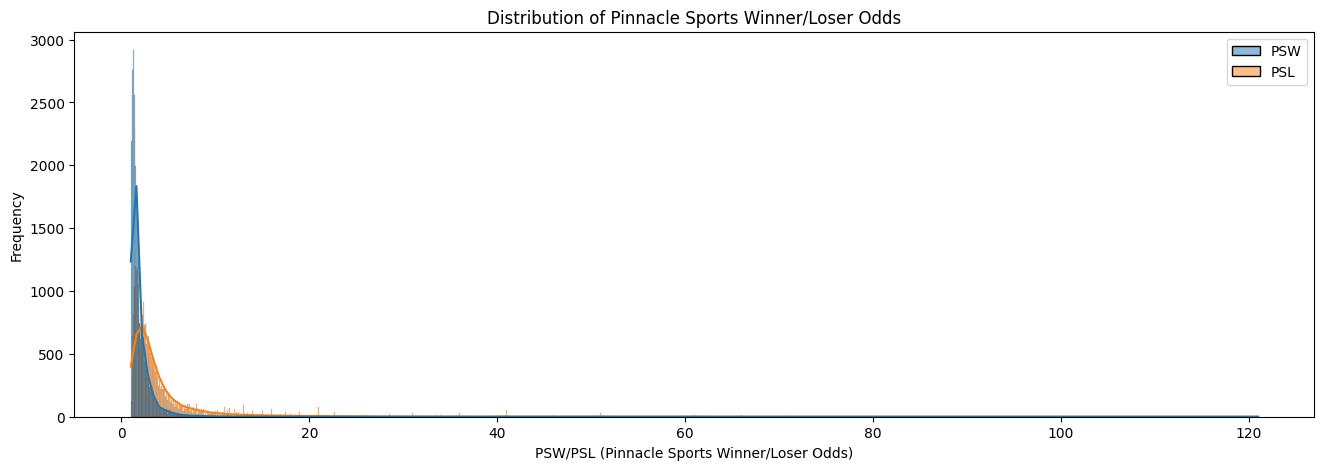

They max on 46.0 (for winners) and 121.0 (for losers).


In [6]:
# Create a histogram of Pinnacle Sports' bets on the the winner
plt.figure(figsize=(16, 5))
sns.histplot(df_atp[["PSW", "PSL"]], kde=True, color=["green", "red"])

# Add labels and title
plt.title('Distribution of Pinnacle Sports Winner/Loser Odds')
plt.xlabel('PSW/PSL (Pinnacle Sports Winner/Loser Odds)')
plt.ylabel('Frequency')

# Show the plot
plt.show()
print(f"They max on {df_atp['PSW'].max()} (for winners) and {df_atp['PSL'].max()} (for losers).")

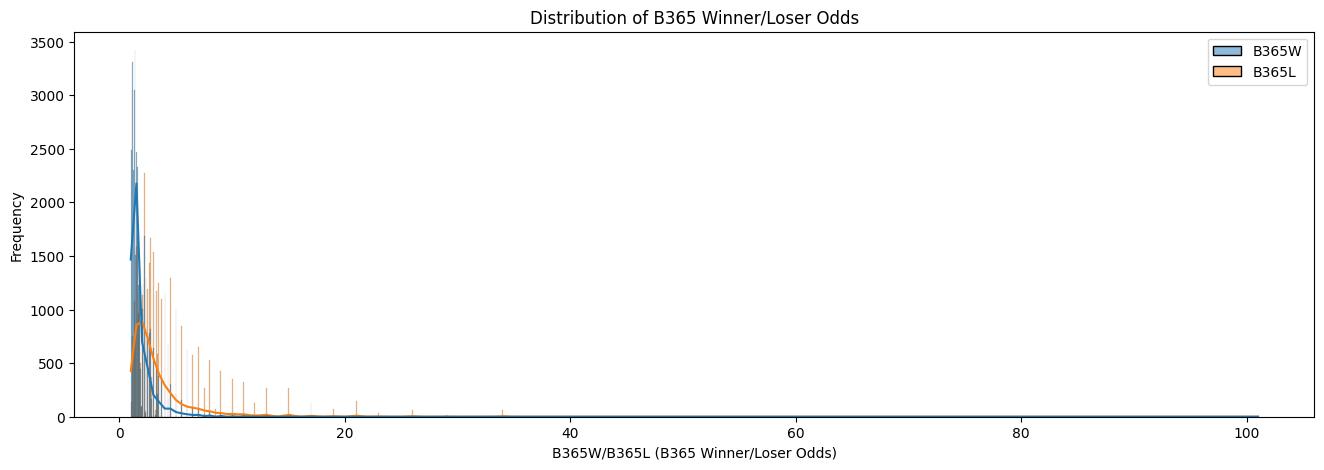

They max on 29.0 (for winners) and 101.0 (for losers).


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a histogram of B365 bets on the the winner
plt.figure(figsize=(16, 5))
sns.histplot(df_atp[["B365W", "B365L"]], kde=True, color=["green", "red"])

# Add labels and title
plt.title('Distribution of B365 Winner/Loser Odds')
plt.xlabel('B365W/B365L (B365 Winner/Loser Odds)')
plt.ylabel('Frequency')

# Show the plot
plt.show()
print(f"They max on {df_atp['B365W'].max()} (for winners) and {df_atp['B365L'].max()} (for losers).")

In [8]:
# Player statistics:
def take_statistics(df: pd.DataFrame):
    # Take out win and loss statistics
    win_count = df["Winner"].value_counts()
    win_count = pd.DataFrame({"Player": win_count.index , "Wins_count": win_count.values})

    loss_count = df["Loser"].value_counts()
    loss_count = pd.DataFrame({"Player": loss_count.index , "Losses_count": loss_count.values})

    # Merge the two dataframes
    players_statistics = loss_count.merge(right=win_count, how="outer", on="Player")
    players_statistics.fillna(value=0 ,inplace=True)

    # Calculate the win ratios
    players_statistics["Games_count"] = players_statistics["Losses_count"] + players_statistics["Wins_count"]
    players_statistics["Win_ratio"] = players_statistics["Wins_count"] / players_statistics["Games_count"]

    # Clean up the columns
    players_statistics[["Games_count", "Wins_count", "Losses_count"]] = players_statistics[["Games_count", "Wins_count", "Losses_count"]].astype("int")
    players_statistics = players_statistics.sort_values(by=["Games_count", "Win_ratio"], ascending=False).reset_index().drop(labels="index", axis=1)

    return players_statistics


# Show first rows
players_statistics = take_statistics(df_atp)
players_statistics.head(10)

print(players_statistics.sort_values(by="Player")["Player"].unique().tolist())

['Abdulla M.', 'Abel M.', 'Acasuso J.', 'Adaktusson J.', 'Agaev E.', 'Agassi A.', 'Agenor R.', 'Ager J.', 'Agostinelli B.', 'Aguilar J.', 'Ahouda A.', 'Al-Alawi S.K.', 'Al-Awadhi O.', 'Al-Ghareeb M.', 'Al-Haji A.', 'Al-Khulaifi N.G.', 'Alami K.', 'Albert M.', 'Albot R.', 'Alcaide G.', 'Aldi F.', 'Ali Mutawa J.M.', 'Allegro Y.', 'Almagro N.', 'Alonso J.', 'Altamirano C.', 'Altmaier D.', 'Alund M.', 'Alvarez E.', 'Alves T.', 'Amritraj P.', 'Ancic I.', 'Ancic M.', 'Andersen J.', 'Andersen J.F.', 'Anderson A.', 'Anderson K.', 'Anderson O.', 'Andersson H.', 'Andreev A.', 'Andreev I.', 'Andreozzi G.', 'Androic T.', 'Andujar P.', 'Aragone J.', 'Aranguren J.M.', 'Arazi H.', 'Arguello F.', 'Armando H.', 'Arnaboldi A.', 'Arnold L.', 'Arthurs W.', 'Arvidsson I.', 'Ascione A.', 'Ascione T.', 'Auckland J.', 'Auger-Aliassime F.', 'Authom M.', 'Awadhy O.', 'Ayala D.', 'Azzaro L.', 'Baccanello P.', 'Bachelot J.F', 'Bachinger M.', 'Baghdatis M.', 'Bagnis F.', 'Bai Y.', 'Baker B.', 'Baker J.', 'Balazs A

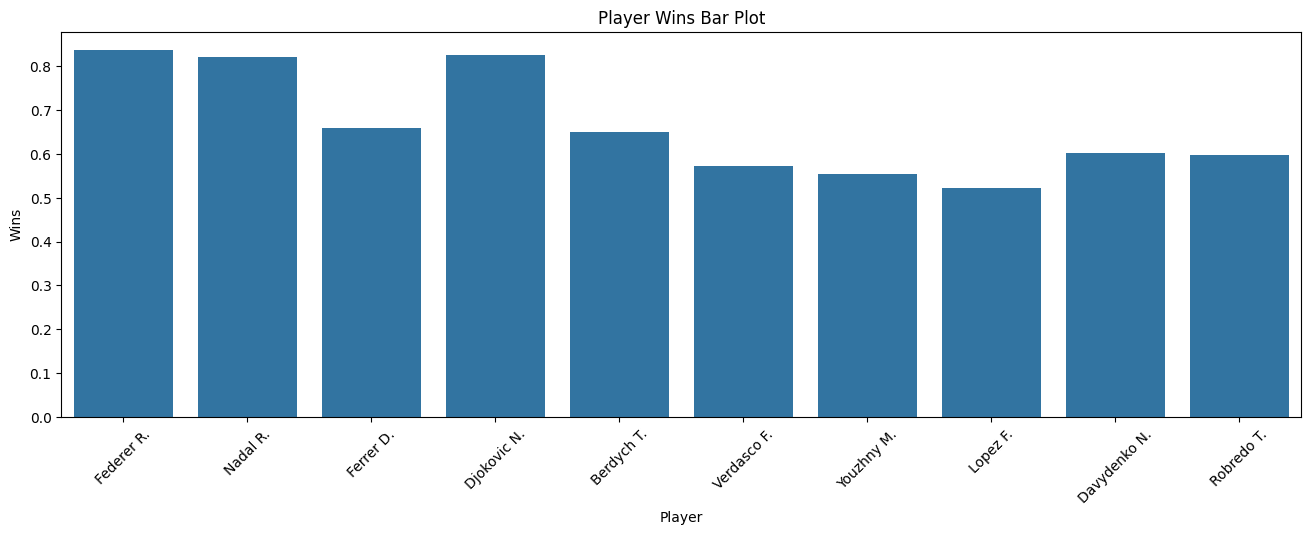

In [9]:
top_n = 10

plt.figure(figsize=(16, 5))
sns.barplot(x=players_statistics["Player"].iloc[:top_n], y=players_statistics["Win_ratio"].iloc[:top_n])

plt.xticks(rotation=45)
plt.xlabel("Player")
plt.ylabel("Wins")
plt.title("Player Wins Bar Plot")

plt.show()

In [10]:
court_types = df_atp["Surface"].unique()

court_specific_player_statistics = {}
for court in court_types:
    court_specific_player_statistics[court] = take_statistics(df_atp[df_atp["Surface"]==court])

court_specific_player_statistics["Clay"].sort_values(by="Win_ratio", ascending=False).head(20)

,Player,Losses_count,Wins_count,Games_count,Win_ratio
2,Nadal R.,33,350,383,0.913838
25,Djokovic N.,41,168,209,0.803828
14,Federer R.,52,187,239,0.782427
401,Nargiso D.,2,7,9,0.777778
91,Thiem D.,22,75,97,0.773196
48,Coria G.,42,106,148,0.716216
171,Agassi A.,14,35,49,0.714286
11,Moya C.,77,185,262,0.706107
388,Stoltenberg J.,3,7,10,0.700000
0,Ferrer D.,121,281,402,0.699005


In [11]:
court_specific_player_statistics["Carpet"].sort_values(by="Win_ratio", ascending=False).head(20)

,Player,Losses_count,Wins_count,Games_count,Win_ratio
8,Nalbandian D.,9,34,43,0.790698
5,Federer R.,11,37,48,0.770833
19,Soderling R.,7,22,29,0.758621
93,Hewitt L.,3,9,12,0.750000
30,Murray A.,6,18,24,0.750000
3,Safin M.,14,39,53,0.735849
38,Baghdatis M.,6,16,22,0.727273
14,Roddick A.,9,23,32,0.718750
126,Rafter P.,2,5,7,0.714286
127,Agassi A.,2,5,7,0.714286


In [13]:
court_specific_player_statistics["Hard"].sort_values(by="Win_ratio", ascending=False).head(20)

,Player,Losses_count,Wins_count,Games_count,Win_ratio
0,Federer R.,111,610,721,0.846047
1,Djokovic N.,84,451,535,0.842991
6,Murray A.,99,367,466,0.787554
67,Agassi A.,46,167,213,0.784038
4,Nadal R.,119,388,507,0.765286
2,Roddick A.,125,383,508,0.753937
218,Sampras P.,16,47,63,0.746032
379,Basic M.,5,13,18,0.722222
18,del Potro J.M.,104,261,365,0.715068
16,Tsonga J.W.,112,258,370,0.697297


In [14]:
court_specific_player_statistics["Grass"].sort_values(by="Win_ratio", ascending=False).head(20)

,Player,Losses_count,Wins_count,Games_count,Win_ratio
0,Federer R.,17,140,157,0.891720
203,Rafter P.,2,12,14,0.857143
2,Murray A.,18,89,107,0.831776
13,Djokovic N.,15,66,81,0.814815
175,Sampras P.,3,13,16,0.812500
4,Roddick A.,18,77,95,0.810526
18,Nadal R.,16,58,74,0.783784
234,Black B.,3,9,12,0.750000
1,Hewitt L.,28,83,111,0.747748
45,Ancic M.,13,37,50,0.740000


# It's time to define some betting strategies:
1. To bet on the higher ranked player (HRBS)
2. To bet on the lower ranked player (LRBS)
3. To bet on a random player (RPBS)
4. To bet on the player with the bettr win ratio (BWRBS)
5. To bet on the player with the better win ratio in the appropirate court type (BWRCTBS)
6. To bet on the winner always (WPBS)
7. To bet on the loser always (LPBS)

Ofcourse, the strategies 5 and 6 are just theoretical and put there to compare the strategies with the theoretical maximum profit.

In [129]:
profit = df_atp[["Surface", "Winner", "Loser", "PSW", "B365W", "elo_winner", "elo_loser", "proba_elo"]].copy()

# Strategy 1
strategies = pd.DataFrame(df_atp["elo_winner"] > df_atp["elo_loser"], columns=["HRBS"], index=df_atp.index)
profit[["HRBS_PS", "HRBS_B365"]] = profit[strategies["HRBS"]][["PSW", "B365W"]].rename(columns={"PSW": "HRBS_PS", "B365W": "HRBS_B365"}) - 1

# Strategy 2
strategies["LRBS"] = df_atp["elo_winner"] < df_atp["elo_loser"]
profit[["LRBS_PS", "LRBS_B365"]] = profit[strategies["LRBS"]][["PSW", "B365W"]].rename(columns={"PSW": "LRBS_PS", "B365W": "LRBS_B365"}) - 1

# Strategy 3
np.random.seed(13572)
strategies["RPBS"] = np.random.randint(0, 2, size=len(strategies))==1
profit[["RPBS_PS", "RPBS_B365"]] = profit[strategies["RPBS"]][["PSW", "B365W"]].rename(columns={"PSW": "RPBS_PS", "B365W": "RPBS_B365"}) - 1

# Strategy 4
strategies["BWRBS"] = profit.merge(players_statistics[["Player", "Win_ratio"]], left_on="Winner", right_on="Player", how="left").set_index(profit.index)["Win_ratio"] > profit.merge(players_statistics[["Player", "Win_ratio"]], left_on="Loser", right_on="Player", how="left").set_index(profit.index)["Win_ratio"]
profit[["BWRBS_PS", "BWRBS_B365"]] = profit[strategies["BWRBS"]][["PSW", "B365W"]].rename(columns={"PSW": "BWRBS_PS", "B365W": "BWRBS_B365"}) - 1

# # Strategy 5
# court_specific_player_statistics[profit["Surface"]]
# profit[["BWRBS_PS", "BWRBS_B365"]] = profit[profit.merge(players_statistics[["Player", "Win_ratio"]], left_on="Winner", right_on="Player", how="left").set_index(profit.index)["Win_ratio"] > profit.merge(players_statistics[["Player", "Win_ratio"]], left_on="Loser", right_on="Player", how="left").set_index(profit.index)["Win_ratio"]][["PSW", "B365W"]].rename(columns={"PSW": "BWRBS_PS", "B365W": "BWRBS_B365"}) - 1
# # To Be Continued

profit.dropna(axis=0, subset=["PSW", "B365W"], inplace=True)
profit.fillna(value=-1.0, inplace=True)

profit.head(20)

,HRBS,LRBS,RPBS,BWRBS
40384,True,False,True,True
38294,True,False,True,True
39399,True,False,True,True
39603,True,False,True,True
39516,True,False,False,True
39994,True,False,True,True
36232,True,False,True,True
39046,True,False,True,True
17239,True,False,True,True
35791,True,False,False,True


In [240]:
# Each cell in the dataframe features answers to the question whether the specified strategy predicts that player one wins
# Before constructing the dataframe we should scramble the players so that sometimes player 1 wins and he loses the other times with equal probabilities.
np.random.seed(98245)
features = pd.DataFrame(np.random.randint(0, 2, size=len(strategies))==1, columns=["P1==Winner"], index=strategies.index)

for feat in strategies.keys():
    features[feat+"_p1"] = ~np.bitwise_xor(features["P1==Winner"], strategies[feat])
    
features.head()

,P1==Winner,HRBS_p1,LRBS_p1,RPBS_p1,BWRBS_p1
40384,False,False,True,False,False
38294,False,False,True,False,False
39399,False,False,True,False,False
39603,False,False,True,False,False
39516,True,True,False,False,True


In [250]:
import sklearn.ensemble
import sklearn.model_selection

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(features.drop(labels=["P1==Winner", "LRBS_p1"], axis=1), features["P1==Winner"], test_size=0.2, random_state=42)

clf = sklearn.ensemble.RandomForestClassifier(max_depth=15, random_state=26895645)
clf.fit(X_train, y_train)

print(f"Random forest with the given features can predict correctly with the probability of {round(clf.score(X_test, y_test)*100, 2)} %")
profits_test = pd.DataFrame({"profit_PS": pd.DataFrame({"result": ~np.logical_xor(clf.predict(X_test), y_test)}, index=y_test.index).replace({True: 1.0, False: 0.0})["result"].to_numpy() * df_atp["PSW"].iloc[y_test.index].to_numpy() - 1.0, "profit_B365": pd.DataFrame({"result": ~np.logical_xor(clf.predict(X_test), y_test)}, index=y_test.index).replace({True: 1.0, False: 0.0})["result"].to_numpy() * df_atp["B365W"].iloc[y_test.index].to_numpy() - 1.0}, index=y_test.index).dropna(axis=0)
profit[["Random_forest_PS", "Random_forest_B365"]] = profits_test
profits_test.describe()
# profit[["Random_forest_PS", "Random_forest_B365"]].describe()
# y_train.iloc[40384]

Random forest with the given features can predict correctly with the probability of 67.6 %


,profit_PS,profit_B365
count,6522.000000,6522.000000
mean,0.311118,0.238912
std,1.415582,1.260257
min,-1.000000,-1.000000
25%,-1.000000,-1.000000
50%,0.290000,0.250000
75%,0.769000,0.660000
max,33.000000,28.000000
